,ds,y
203,2021-12-01,290.8
204,2022-01-01,328.8
205,2022-02-01,214.5
206,2022-03-01,287.0
207,2022-04-01,370.0


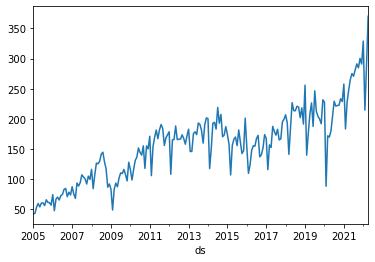

In [18]:
"""
Created on Sun Jul 17 00:00:09 2022

@author: whh

vx: 15967946943

功能：已知2005-01-01到2021-12-01进出口贸易额，抽取2017-2021五年的数据，用Prophet模型预测2022年 1& 2& 3& 4& 5 未来五个月的进出口贸易额。
"""


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet


# 1.读入数据
Alldata = pd.read_csv('./贸易额.csv', encoding='gbk')[['时间', '贸易额']]



# 2.数据预处理
#prophet模型强制表格列名形式以['ds', 'y']出现
Alldata.columns = ['ds', 'y']   

# 时间格式转换
Alldata['ds'] = Alldata['ds'].apply(pd.to_datetime)
Alldata.set_index('ds').y.plot()
Alldata.tail()

In [19]:
# 取对数，使序列数据平稳化
Alldata.y = Alldata.y.apply(np.log2)
Alldata.y.tail()

203    8.183883
204    8.361066
205    7.744834
206    8.164907
207    8.531381
Name: y, dtype: float64

In [20]:
# 3.划分train、test
# split_len：划分train/test的个数
split_len1 = 144
split_len2 = -4
train, test =  Alldata[split_len1 : split_len2], Alldata[split_len2 : ]


# 4.模型拟合
prophet = Prophet(seasonality_mode='multiplicative').fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
# 5.预测
# forecast_month：预测train后的未来几个月
forecast_month = 5
future = prophet.make_future_dataframe(periods=(5), freq='MS') 
forecast = prophet.predict(future)


# 使数据以['yhat', 'yhat_lower', 'yhat_upper', 'y']（[‘预测值’，‘预测下区间’，‘预测下区间’，‘真实值’]）格式呈现。
def comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))
cmp_df = comparison_dataframe(Alldata, forecast).apply(np.exp2)    #反log
cmp_df.tail(10)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2021-08-01,287.168315,262.447251,316.330980,281.3
2021-09-01,283.115279,256.714646,312.011927,291.1
2021-10-01,278.192230,251.531646,306.501145,284.6
2021-11-01,299.469304,272.304383,333.376505,300.2
2021-12-01,295.386563,265.842914,325.733285,290.8
2022-01-01,338.309579,305.692803,371.378626,328.8
2022-02-01,215.021325,194.766666,237.940162,214.5
2022-03-01,265.133716,239.248011,293.261452,287.0
2022-04-01,309.814166,280.215322,339.039075,370.0


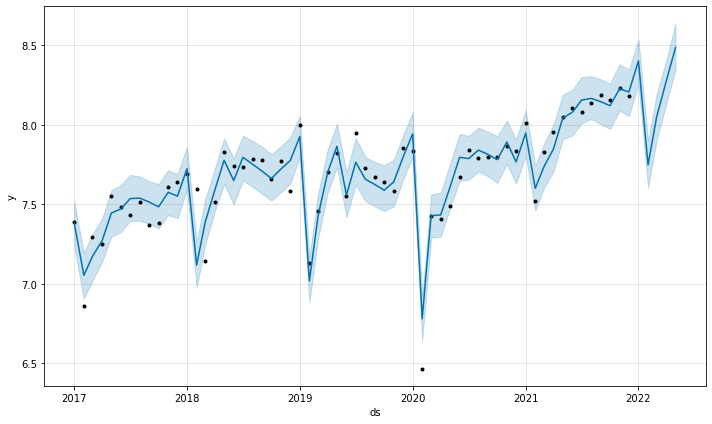

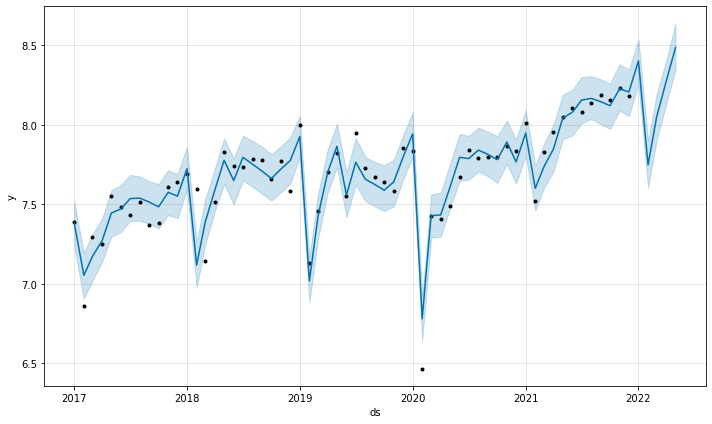

In [22]:
# 6.预测结果可视化
prophet.plot(forecast)